In [1]:
from pathlib import Path

import multiprocessing as mp

import numpy as np
import pandas as pd

import openmdao.api as om

import matplotlib.pyplot as plt
import seaborn as sns

import nsga2_weis.algo.fast_nondom_sort


In [2]:
def load_OMsql(log):
    print("loading {}".format(log))
    cr = om.CaseReader(log)
    rec_data = {}
    #driver_cases = cr.list_cases("driver")
    cases = cr.get_cases("driver")
    for case in cases:
        for key in case.outputs.keys():
            if key not in rec_data:
                rec_data[key] = []
            rec_data[key].append(case[key])

    return rec_data

In [3]:
# Multiprocssing?
post_multi = False

# sql outfile directory
run_dir = Path.cwd()
output_dir = run_dir / "outputs" / "04_iea22_raft_opt"
doe_logs = list(output_dir.glob("log_opt.sql*"))
N_logs = len(doe_logs)
if N_logs < 1: raise FileExistsError("No output logs to post process!")

In [4]:
# Remove the "meta" log
for idx, log in enumerate(doe_logs):
    if "meta" in log.suffix:
        doe_logs.pop(idx)
        N_logs -= 1
doe_logs

[PosixPath('/Users/cfrontin/codes/WEIS/examples/04_frequency_domain_analysis_design/outputs/04_iea22_raft_opt/log_opt.sql_2'),
 PosixPath('/Users/cfrontin/codes/WEIS/examples/04_frequency_domain_analysis_design/outputs/04_iea22_raft_opt/log_opt.sql_0'),
 PosixPath('/Users/cfrontin/codes/WEIS/examples/04_frequency_domain_analysis_design/outputs/04_iea22_raft_opt/log_opt.sql_1')]

In [5]:
# run multiprocessing
if post_multi:
    cores = mp.cpu_count()
    pool = mp.Pool(min(N_logs, cores))

    # load sql file
    outdata = pool.map(load_OMsql, doe_logs)
    pool.close()
    pool.join()
# no multiprocessing
else:
    outdata = [load_OMsql(log) for log in doe_logs]

collected_data = {}
for data in outdata:
    for key in data.keys():
        if key not in collected_data.keys():
            collected_data[key] = []

        for key_idx, _ in enumerate(data[key]):
            if isinstance(data[key][key_idx], int):
                collected_data[key].append(np.array(data[key][key_idx]))
            elif len(data[key][key_idx]) == 1:
                try:
                    collected_data[key].append(float(data[key][key_idx][0]))
                except:
                    collected_data[key].append(np.array(data[key][key_idx]))
            else:
                collected_data[key].append(np.array(data[key][key_idx]))

df = pd.DataFrame.from_dict(collected_data)
df["pareto_rank_noconstraint"] = nsga2_weis.algo.fast_nondom_sort.fast_nondom_sort_ranks(df[["floatingse.system_structural_mass", "raft.Max_PtfmPitch", "raft.Std_PtfmPitch"]].to_numpy())
df["pareto_noconstraint"] = df["pareto_rank_noconstraint"] == 0

# write to file
outdata_fname = "nsga2_outdata"
outdata_fpath = output_dir / outdata_fname
df.to_csv(outdata_fpath.with_suffix(".csv"), index=False)
print("Saved {}".format(outdata_fpath.with_suffix(".csv")))
# FileTools.save_yaml(output_dir, outdata_fname + ".yaml", collected_data, package=2)

loading /Users/cfrontin/codes/WEIS/examples/04_frequency_domain_analysis_design/outputs/04_iea22_raft_opt/log_opt.sql_2
loading /Users/cfrontin/codes/WEIS/examples/04_frequency_domain_analysis_design/outputs/04_iea22_raft_opt/log_opt.sql_0
loading /Users/cfrontin/codes/WEIS/examples/04_frequency_domain_analysis_design/outputs/04_iea22_raft_opt/log_opt.sql_1
Saved /Users/cfrontin/codes/WEIS/examples/04_frequency_domain_analysis_design/outputs/04_iea22_raft_opt/nsga2_outdata.csv


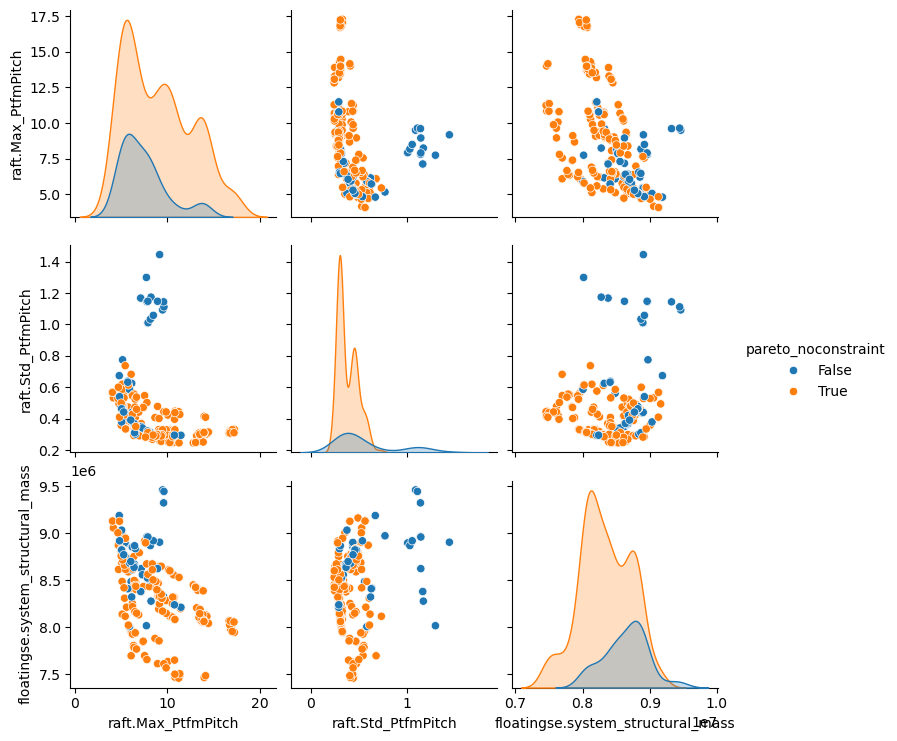

In [6]:
sns.pairplot(
    df[[
        "raft.Max_PtfmPitch",
        "raft.Std_PtfmPitch",
        "floatingse.system_structural_mass",
        "pareto_noconstraint",
    ]],
    vars=[
        "raft.Max_PtfmPitch",
        "raft.Std_PtfmPitch",
        "floatingse.system_structural_mass",
    ],
    hue="pareto_noconstraint",
)

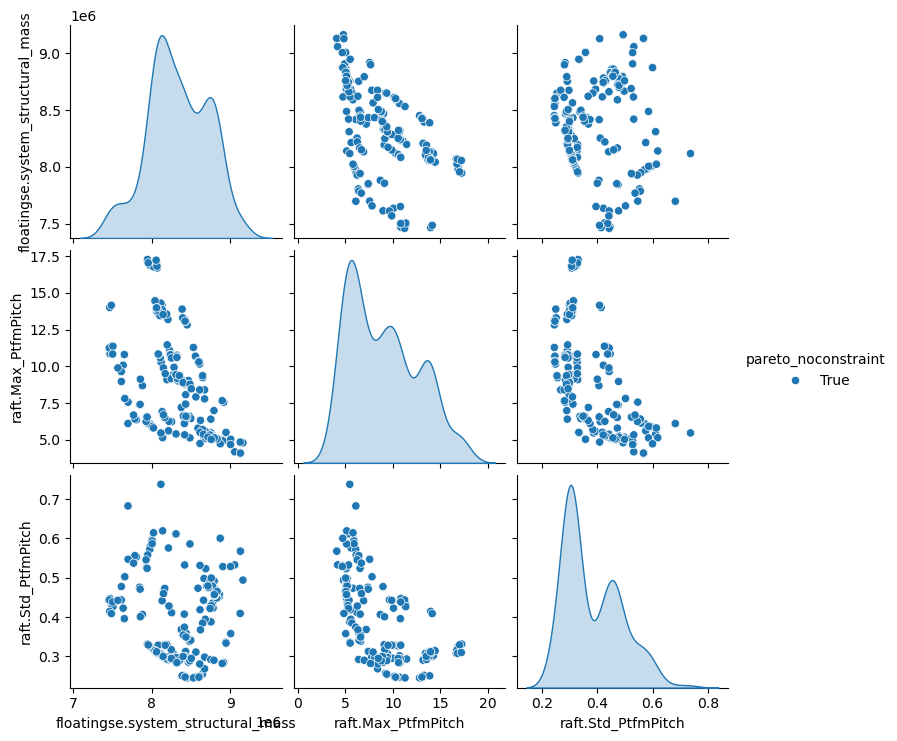

In [7]:
sns.pairplot(
    (df[df.pareto_rank_noconstraint == 0])[[
        "floatingse.system_structural_mass",
        "raft.Max_PtfmPitch",
        "raft.Std_PtfmPitch",
        "pareto_noconstraint",
    ]],
    vars=[
        "floatingse.system_structural_mass",
        "raft.Max_PtfmPitch",
        "raft.Std_PtfmPitch",
    ],
    hue="pareto_noconstraint",
)

In [9]:
import plotly.graph_objects as go

fig = go.Figure(
    data=go.Splom(
        dimensions=[
            {"label": k, "values": v} for k, v in df[[
                "floatingse.system_structural_mass",
                "raft.Max_PtfmPitch",
                "raft.Std_PtfmPitch",
                # "pareto_noconstraint",
            ]].to_dict(orient="list").items()
        ],
        # showupperhalf=False,
        diagonal_visible=False,
        # text=df["pareto_noconstraint"],
        marker={
            "color": df.index,
            "showscale": False,
            "line_color": "white",
            "line_width": 0.5,
        }
    )
)

fig.update_layout(
    # title=dict(text="Pareto ÷front"),
    hoversubplots="axis",
    width=600,
    height=600,
    hovermode="x",
)
